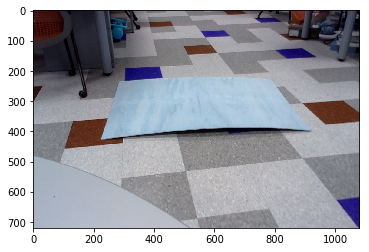

In [1]:
# Find edges

import imutils
import cv2 as cv
import numpy as np
import random as rng

from matplotlib import pyplot as plt
%matplotlib inline
src = cv.imread('images/test_wood.png')
graysrc = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
plt.imshow(src)

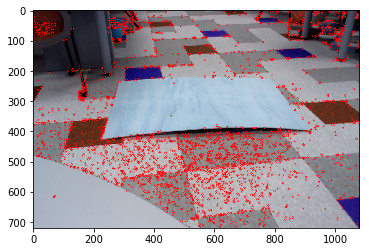

In [2]:
# Fast Detection (Optimal for resource limited devices)
fast = cv.FastFeatureDetector_create()

kp = fast.detect(src, None)
fast_src = cv.drawKeypoints(src, kp, None, color=(255,0,0))
plt.imshow(fast_src)

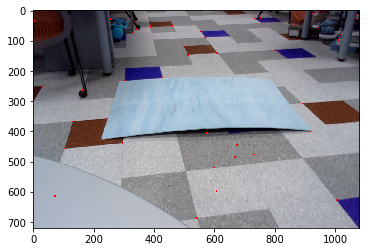

In [3]:
# Good Feature Detection (finds corners well)
corners = cv.goodFeaturesToTrack(graysrc, 50, 0.01, 10)
corners = np.int0(corners)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv.circle(src,(x,y),3,255,-1)

plt.imshow(src)

(255.0, 0.0, 0.0, 0.0)


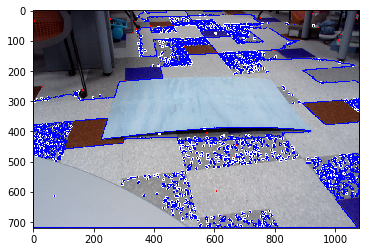

In [4]:

# convert to binary image
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1) #1, 2)

# Many Moments
for c in contours:
    M = cv.moments(c)
    
    if (M['m00'] != 0):
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
    else:
        cx, cy = 0,0
        
    cv.circle(src, (cx,cy),5, (255,255,255), -1)
        
#src2 = cv.imread('images/srcimg.png')
#for i in range(cx):
#    cv.circle(src2, (cx_arr[i],cx_arr[i]),3, 255, -1)
    
# Draw all contours
cv.drawContours(src, contours, -1, (0,0,255), 2)
    
plt.imshow(src)

# Find largest contour in image (todo)
# Find angle at which object is directed
#      ^ -- (x,y),(MA,ma),angle = cv.fitEllipse(cnt)
mask = np.zeros(graysrc.shape, np.uint8)
cv.drawContours(mask, contours, 0,255,-1)

cnt = contours[0]
leftmost = tuple(cnt[cnt[:,:,0].argmin()][0])
rightmost = tuple(cnt[cnt[:,:,0].argmin()][0])
topmost = tuple(cnt[cnt[:,:,1].argmin()][0])
bottommost = tuple(cnt[cnt[:,:,1].argmin()][0])

extreme_pts = [leftmost, rightmost, topmost, bottommost]
for i in range(len(extreme_pts)):
    cv.circle(src, (extreme_pts[i][0],extreme_pts[i][1]), 3, 255, -1)
    
    
mean_val = cv.mean(src, mask=mask)
print(mean_val)


In [5]:
# This block will print all contours' locations, areas, and perimters

# Define globals
board = None

# Empirically derived constants:
wood_perimeter_range = range(450, 550) # fuck this depends on distance

# Start over by reloading images
src = cv.imread('images/test_wood.png')
graysrc = cv.cvtColor(src, cv.COLOR_BGR2GRAY)

# convert to binary image
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1) #1, 2)

# temp
mask = np.zeros(np.shape(src))
mask[450:550,250:600] = 1;
# temp

print('All contours: ')
for cnt in contours:
    M = cv.moments(cnt)
    if (M['m00'] != 0):
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        if (cx not in range(250,600) or cy not in range(250, 350)):
            continue
        area = cv.contourArea(cnt)
        perimeter = cv.arcLength(cnt,True)
        print('cx: ', cx, '\tcy: ', cy, '\tarea: ', area, '\tperimeter: ', perimeter, '\tcontourLength: ', len(cnt))
        cv.drawContours(src, cnt, -1, (0,0,255), 2)
        
        if (int(perimeter) in range(450, 550)): # must convert double to int for range comparison
            board = cnt
        
print('\n')

if (board is not None):
    # draw contours for board
    cv.drawContours(src, board, -1, (250, 0, 0), 3)
    # get mask
    mask = np.zeros(graysrc.shape,np.uint8)
    cv.drawContours(mask,[board],0,255,cv.FILLED)
    # get all the pixels of the board
    pixelpoints = np.transpose(np.nonzero(mask))
    plt.imshow(mask)
    plt.figure()

    print('mean color: ', cv.mean(src, mask=mask))
        
    board_color_mean = cv.mean(src, mask=mask)

    # fill the board contour with its average color
    cv.drawContours(src, [board], 0, board_color_mean, cv.FILLED)
plt.imshow(src)


All contours: 




NameError: name 'board_color_mean' is not defined